In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, FloatType

import string
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import ruptures as rpt
from matplotlib import cm
from sklearn.decomposition import PCA
import random
import seaborn as sns

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[18]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

In [3]:
schema = StructType([
    StructField("bigram", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("count", IntegerType(), True),
    StructField("bigram_percent", DoubleType(), True),
    StructField("medianA",  DoubleType(), True),
    StructField("ntileA", IntegerType(), True),
    StructField("medianB",  DoubleType(), True),
    StructField("ntileB", IntegerType(), True),
    StructField("label", IntegerType(), True),
    StructField("start_of_mainstreaming", IntegerType(), True),
    StructField("end_of_mainstreaming", IntegerType(), True),
    StructField("peak_year", IntegerType(), True)])

In [4]:
df_load = spark.read.option('header', False).schema(schema)\
                     .csv('/data/shared1/cleandata/changepoint_annotated_allntiles_newer')

In [5]:
# Only take the mainstream bigrams
df = df_load.where(col('label')==1)

### Load pretrained model

In [6]:
import gensim.downloader

In [7]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [8]:
import json
info = gensim.downloader.info('word2vec-google-news-300')
print(json.dumps(info, indent=4))

{
    "num_records": 3000000,
    "file_size": 1743563840,
    "base_dataset": "Google News (about 100 billion words)",
    "reader_code": "https://github.com/RaRe-Technologies/gensim-data/releases/download/word2vec-google-news-300/__init__.py",
    "license": "not found",
    "parameters": {
        "dimension": 300
    },
    "description": "Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).",
    "read_more": [
        "https://code.google.com/archive/p/word2vec/",
        "https://arxiv.org/abs/1301.3781",
        "https://arxiv.org/abs/1310.4546",
        "https://www.microsoft.com/en-us/research/publication/linguistic-regularities-in-continuous-space-word-representatio

In [9]:
word2vec = gensim.downloader.load('word2vec-google-news-300')

### Prepare data

In [11]:
categories = ['analysis', 'science', 'health', 'food', 'data', 'banking', 'culture',
             'environment', 'networks', 'government', 'military',
             'infrastructure', 'politics', 'drugs', 'technology',
             'patients', 'industry', 'internet', 'literature', 'society', 'business', 'religion', 
              'education', 'media', 'sexuality', 'sustainability', 'space',
             'software', 'farming', 'children']
categories.sort()

In [12]:
bigramdf = df.select('bigram').toPandas()
bigrams = bigramdf.bigram.unique()

In [13]:
def categorize(bigrams, categories):
    no_embedding = 0
    drop = []
    for i in range(0, len(bigrams)):
        bigrams[i] = bigrams[i].replace('_adj', '')
        bigrams[i] = bigrams[i].replace('_noun', '')
        bigrams[i] = bigrams[i].split(' ')
    
    categoryDict = dict()
    for cat in categories:
        categoryDict[cat] = []
        
    for j in bigrams:
        count = 0
        largest_sim = 0
        for key, val in categoryDict.items():
            try:
                sim = word2vec.n_similarity(j, [key])
            except:
                no_embedding = no_embedding + 1;
                continue

            if (largest_sim < sim) & (sim <= 0.99):
                category = key
                largest_sim = sim
        if largest_sim >= 0.45:
            categoryDict[category].append(str((' ').join(j)))    
        else:
            drop.append(j)
            
    return categoryDict, drop, no_embedding/30

In [14]:
categoryDict, drop, no_embedding = categorize(bigrams, categories)

In [15]:
# number of bigrams in each category
valsum=0
for key, val in categoryDict.items():
    print(key, len(val))
    valsum += len(val)
print('total no. of bigrams in categories:', valsum)

analysis 818
banking 241
business 452
children 446
culture 457
data 814
drugs 304
education 620
environment 256
farming 223
food 227
government 374
health 415
industry 401
infrastructure 317
internet 216
literature 252
media 227
military 223
networks 353
patients 467
politics 484
religion 345
science 522
sexuality 259
society 258
software 444
space 199
sustainability 242
technology 792
total no. of bigrams in categories: 11648


### Plot

In [16]:
def make_vocab(categories, bigrams, categoryDict):
    vocab = categories
    X = word2vec[vocab]
    categorylist = []
    
    for bigram in bigrams:
        cleanbigram = str((' ').join(bigram))
        for key, val in categoryDict.items():
            if (cleanbigram in key) | (cleanbigram in val):
                try:
                    X = np.append(X, np.array((word2vec[bigram[0]] + word2vec[bigram[1]])/2).reshape(1, 300), axis=0)
                    vocab.append(cleanbigram)
                except:
                    continue
                    
    categorylist = []
    for v in vocab:
        for key, val in categoryDict.items():
            if (v in key) | (v in val):
                categorylist.append(key)
                
    return X, vocab, categorylist

In [17]:
def pca_dataframe(X, vocab, categorylist):
    pca = PCA(n_components=3, random_state=11, whiten=True)
    clf = pca.fit_transform(X)
    
    data = list(zip(clf, vocab, categorylist))
    tmp = pd.DataFrame(data, columns=['coord', 'bigram', 'category'])
    return tmp

In [18]:
def generate_colors(categoryDict, vocab, top_categories):
    
    topcategoriesDict = {key: categoryDict[key] for key in top_categories}
    colors = cm.get_cmap('rainbow', len(topcategoriesDict))
    
    colormap = dict()
    i = 0
    for key in topcategoriesDict:
        colormap[key] = colors(np.linspace(0, 1, len(topcategoriesDict)))[i]
        i = i + 1
        
    colorlist = []
    for i in range(0, len(vocab)):
        for key, val in topcategoriesDict.items():
            if (vocab[i] in key) | (vocab[i] in val):
                colorlist.append(colormap[key])
    
    return colorlist, colormap

In [19]:
X, vocab, categorylist = make_vocab(categories, bigrams, categoryDict)
categories = ['analysis', 'science', 'health', 'food', 'data', 'banking', 'culture',
             'environment', 'networks', 'government', 'military',
             'infrastructure', 'politics', 'drugs', 'technology',
             'patients', 'industry', 'internet', 'literature', 'society', 'business', 'religion', 
              'education', 'media', 'sexuality', 'sustainability', 'space',
             'software', 'farming', 'children']
categories.sort()

In [20]:
tmp = pca_dataframe(X, vocab, categorylist)

In [21]:
top_categories = ['technology', 'analysis', 'data', 'science', 'education', 'politics', 'culture', 
                  'business', 'patients', 'children']
top_categories.sort()
tmp = tmp[tmp.category.isin(top_categories)]

In [22]:
colorlist, colormap = generate_colors(categoryDict, list(tmp.bigram), top_categories)

In [23]:
tmp.head()

,coord,bigram,category
0,"[1.9314957, 1.6109573, 3.129993]",analysis,analysis
2,"[0.42417574, -1.5362287, -0.9561992]",business,business
3,"[-1.7338687, 1.1812491, -1.9741998]",children,children
4,"[-1.7157902, -1.3055756, 1.207881]",culture,culture
5,"[3.3103604, 0.9964951, 1.2406502]",data,data


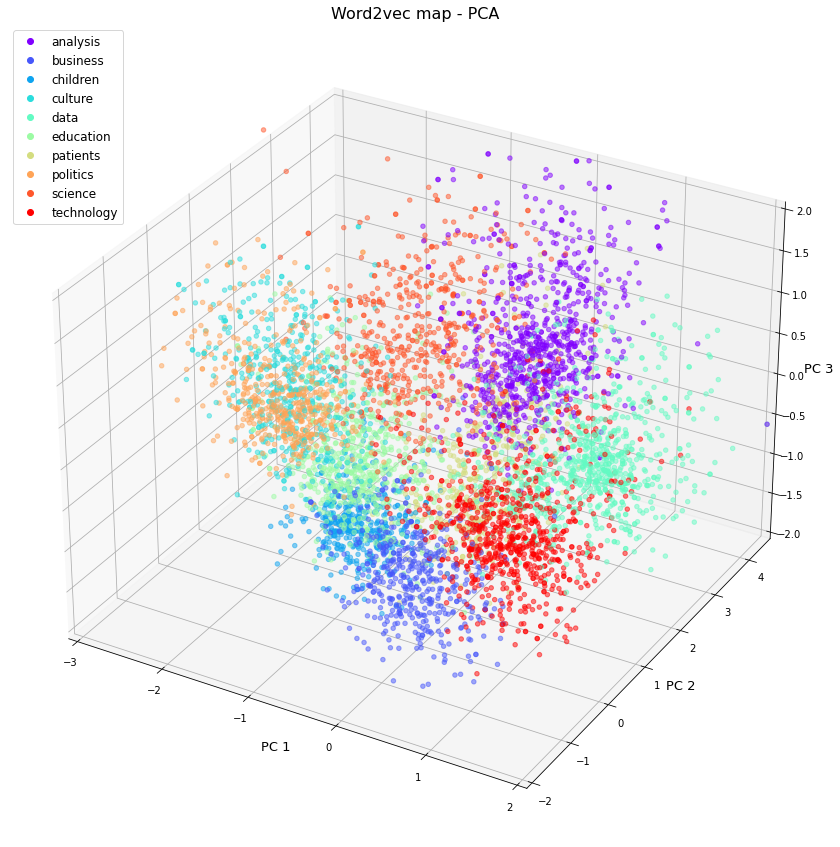

In [24]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

x = tmp.coord.map(lambda coord: coord[0])
y = tmp.coord.map(lambda coord: coord[1])
z = tmp.coord.map(lambda coord: coord[2])

ax.scatter(x, y, z, c=colorlist, alpha = 0.5)
ax.set_zlim3d(-2, 2)
ax.set_xlim3d(-3, 2)
ax.set_ylim3d(-2, 4.5)
ax.set_xlabel('PC 1', fontsize=13)
ax.set_ylabel('PC 2', fontsize=13)
ax.set_zlabel('PC 3', fontsize=13)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colormap.values()]

plt.legend(markers, colormap.keys(), loc='upper left', fontsize=12)
plt.title('Word2vec map - PCA', fontsize=16)
plt.savefig('PCA_3D')
plt.show()

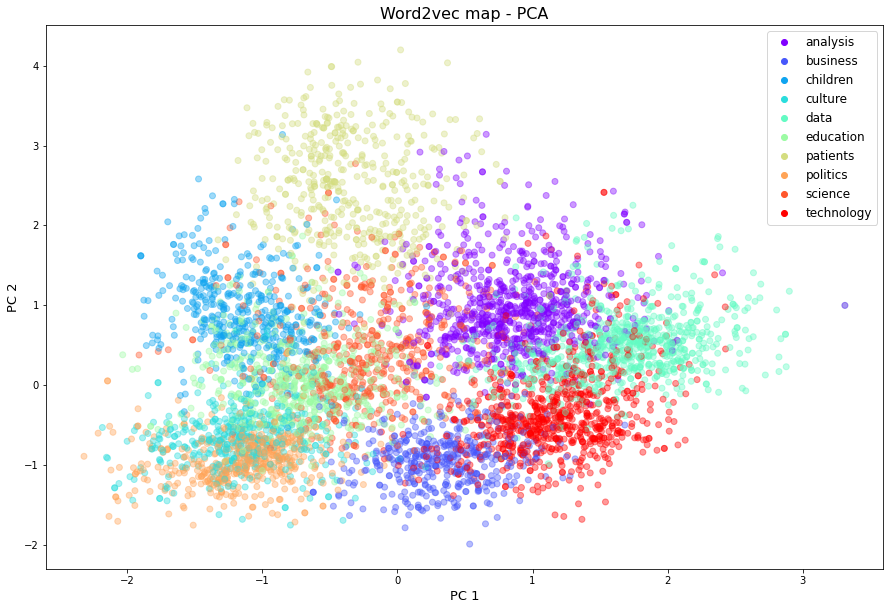

In [25]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

x = tmp.coord.map(lambda coord: coord[0])
y = tmp.coord.map(lambda coord: coord[1])

ax.scatter(x, y, c=colorlist, alpha = 0.4)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colormap.values()]

plt.legend(markers, colormap.keys(), fontsize=12)
plt.xlabel('PC 1', fontsize=13)
plt.ylabel('PC 2', fontsize=13)
plt.title('Word2vec map - PCA', fontsize=16)
plt.savefig('PCA_2D')
plt.show()

### Category plots

In [26]:
plotdf = df.select('bigram', 'peak_year', 'count', 'year', 'start_of_mainstreaming').where(df.year == df.peak_year)
plotdf = plotdf.drop('year')

In [27]:
plotpd = plotdf.toPandas()

In [28]:
bigramlist = []
for b in plotpd.bigram:
    b = b.replace('_adj', '')
    b = b.replace('_noun', '')
    bigramlist.append(b)

In [29]:
plotpd.bigram = bigramlist
plotpd = plotpd[plotpd.bigram.isin(vocab)]

In [30]:
categorylist = []
for bigram in list(plotpd.bigram):
    for key, val in categoryDict.items():
        if bigram in val:
            categorylist.append(key)

In [31]:
plotpd['category'] = categorylist

In [32]:
plotpd.head()

,bigram,peak_year,count,start_of_mainstreaming,category
2,academic affairs,1983,2775,1962,education
5,acute asthma,2005,3416,1985,patients
8,african literature,1986,7149,1968,literature
28,bank marketing,1986,2469,1972,banking
29,banking organizations,1988,9371,1970,banking


In [33]:
plotpd_top = plotpd[plotpd.category.isin(top_categories)]
plotpd_top = plotpd_top.reset_index()

In [35]:
# top three bigrams from each top category
topcategoriesDict = {key: categoryDict[key] for key in top_categories}

for key in topcategoriesDict:
    tmp = plotpd_top[plotpd_top.category == key]
    tmp = tmp.sort_values('count', ascending=False)
    tmp = tmp.reset_index()
    print("Top five bigrams in category \"" + key + "\":")
    for i in range(0, 5):
        print(tmp.bigram[i] + ", count = " + str(tmp['count'][i]), ", peak year = " + str(tmp['peak_year'][i]))
    print("\n")

Top five bigrams in category "analysis":
risk assessment, count = 146476 , peak year = 1995
qualitative research, count = 79529 , peak year = 2016
research process, count = 43399 , peak year = 2016
impact assessment, count = 41052 , peak year = 1999
discourse analysis, count = 38836 , peak year = 2016


Top five bigrams in category "business":
business model, count = 79881 , peak year = 2019
business process, count = 68658 , peak year = 2010
business plan, count = 55733 , peak year = 2010
business models, count = 52694 , peak year = 2019
investment tax, count = 52017 , peak year = 1981


Top five bigrams in category "children":
baby girl, count = 44809 , peak year = 2014
child left, count = 33328 , peak year = 2007
child pornography, count = 32152 , peak year = 2003
no child, count = 30025 , peak year = 2007
baby boomers, count = 26272 , peak year = 1998


Top five bigrams in category "culture":
cultural studies, count = 61198 , peak year = 2002
cultural identity, count = 56175 , peak 

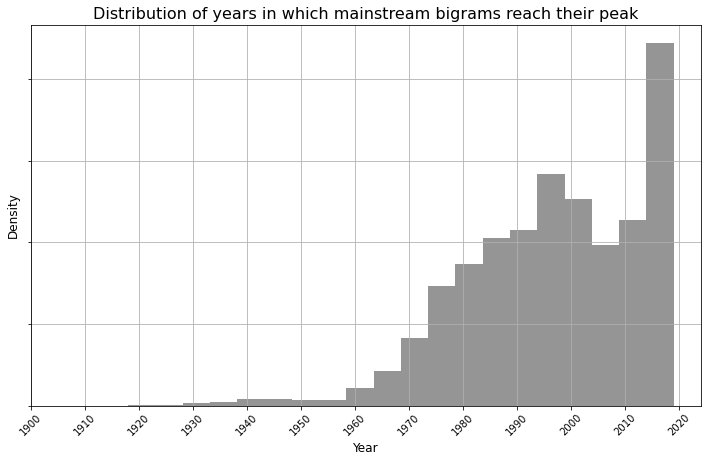

In [89]:
fig, ax = plt.subplots(figsize=(12,7))

plt.hist(plotpd['peak_year'], color='dimgrey', bins=20, alpha=0.7)

plt.xlabel('Year', fontsize='12')
plt.ylabel('Density', fontsize='12')
plt.grid()
x = np.arange(1900,2021,10)
plt.xticks(x, fontsize=10, rotation=45, labels=x)
ax.set_yticklabels([])
plt.title('Distribution of years in which mainstream bigrams reach their peak', fontsize='16')
plt.savefig('AllCategoriesHist')  
plt.show()

<Figure size 432x288 with 0 Axes>

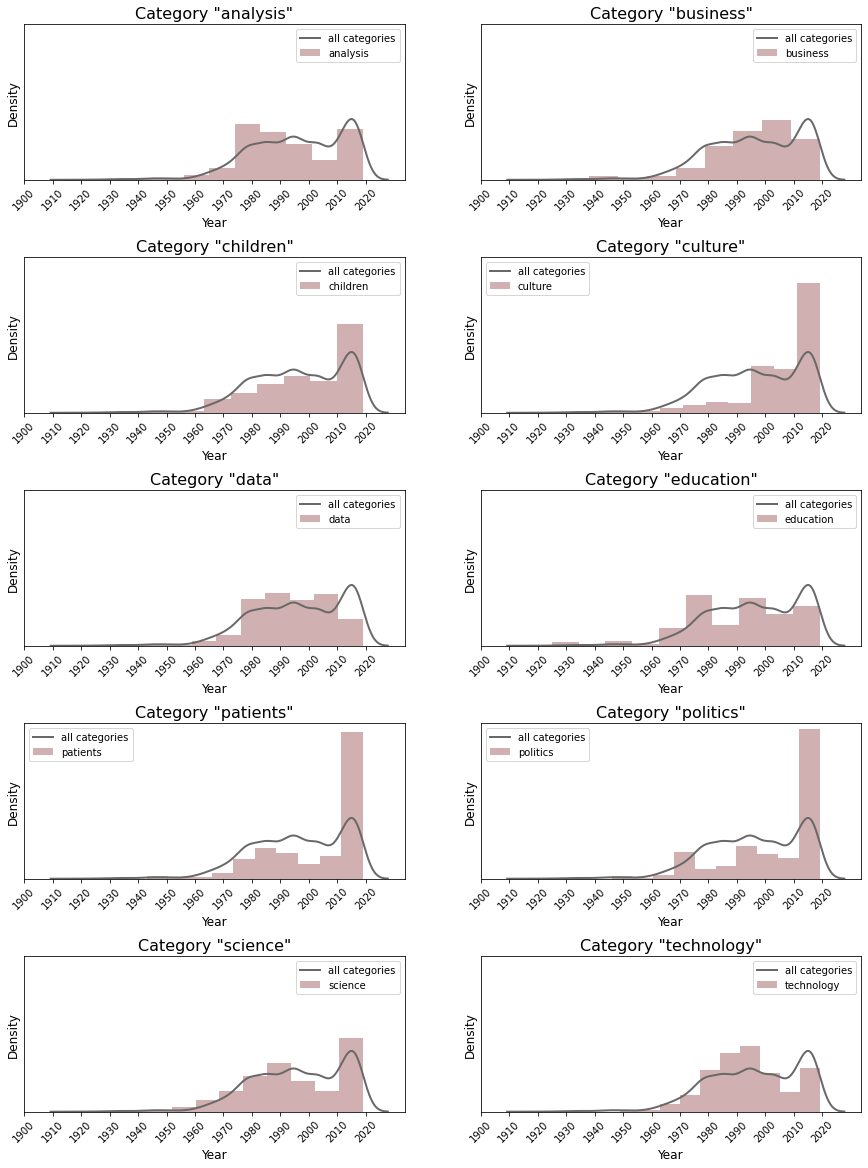

In [98]:
import scipy.stats as stats

# only for top categories
fig = plt.figure()
plt.figure(figsize=(15,20))

i = 1
for key in topcategoriesDict:
    plt.subplot(5, 2, i)
    plt.subplots_adjust(hspace = 0.5)
    
    plt.hist(plotpd_top[plotpd_top.category == key]['peak_year'], alpha=0.7, density=True, 
             label=key, color='rosybrown')
    sns.kdeplot(plotpd_top['peak_year'], color = 'dimgrey', linewidth=2, label='all categories')
    
    
    plt.xlabel('Year', fontsize='12')
    plt.ylabel('Density', fontsize='12')
    plt.yticks([])
    plt.legend()
    x = np.arange(1900,2021,10)
    plt.xticks(x, fontsize=10, rotation=45, labels=x)
    plt.ylim([0, 0.075])
    plt.title('Category \"' + str(key) + '\"', fontsize='16')
    i += 1
plt.savefig('TopCategoryHistograms')  
plt.show()

<Figure size 432x288 with 0 Axes>

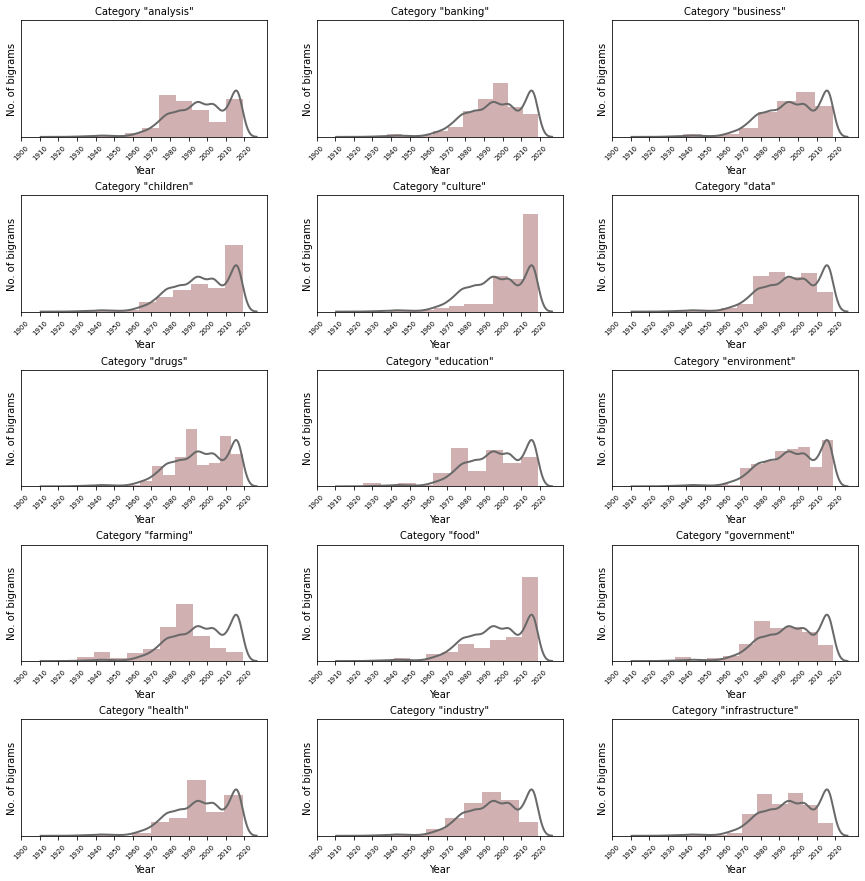

In [102]:
# for all categories
fig = plt.figure()
plt.figure(figsize=(15,15))

i = 1
for key in list(categoryDict.keys())[0:15]:
    plt.subplot(5, 3, i)
    plt.subplots_adjust(hspace = 0.5)
    
    plt.hist(plotpd[plotpd.category == key]['peak_year'], alpha=0.7, density=True, 
             label=key, color='rosybrown')
    sns.kdeplot(plotpd['peak_year'], color = 'dimgrey', linewidth=2, label='all categories')
    
    plt.xlabel('Year', fontsize='10')
    plt.ylabel('No. of bigrams', fontsize='10')
    plt.yticks([])
    x = np.arange(1900,2021,10)
    plt.xticks(x, fontsize=7, rotation=45, labels=x)
    plt.ylim([0, 0.075])
    plt.title('Category \"' + str(key) + '\"', fontsize='10')
    i += 1
plt.savefig('CategoryHistograms1')  
plt.show()

<Figure size 432x288 with 0 Axes>

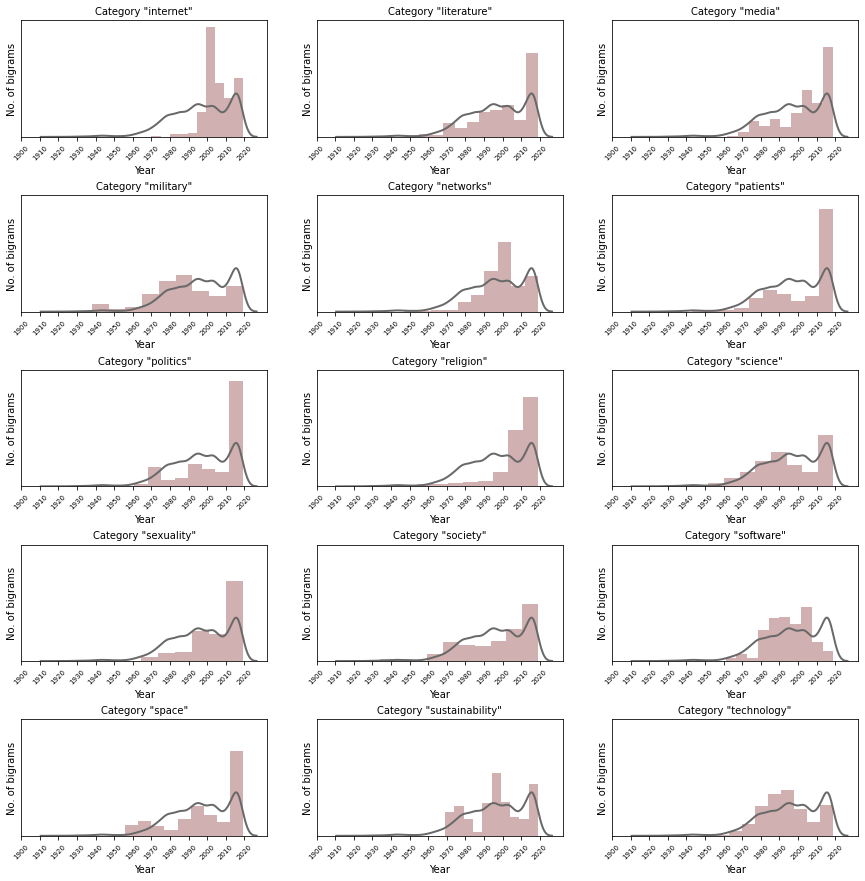

In [103]:
# for all categories
fig = plt.figure()
plt.figure(figsize=(15,15))

i = 1
for key in list(categoryDict.keys())[15:]:
    plt.subplot(5, 3, i)
    plt.subplots_adjust(hspace = 0.5)
    
    plt.hist(plotpd[plotpd.category == key]['peak_year'], alpha=0.7, density=True, 
             label=key, color='rosybrown')
    sns.kdeplot(plotpd['peak_year'], color = 'dimgrey', linewidth=2, label='all categories')
    
    plt.xlabel('Year', fontsize='10')
    plt.ylabel('No. of bigrams', fontsize='10')
    plt.yticks([])
    x = np.arange(1900,2021,10)
    plt.xticks(x, fontsize=7, rotation=45, labels=x)
    plt.ylim([0, 0.08])
    plt.title('Category \"' + str(key) + '\"', fontsize='10')
    i += 1
plt.savefig('CategoryHistograms2')  
plt.show()

### Wordclouds for some categories 

In [104]:
def generate_corpus(plotpd, categories):
    wordcloud_data = plotpd[plotpd.category.isin(categories)]
    
    corpus = dict()
    for cat in categories:
        counts = list(wordcloud_data[wordcloud_data.category == cat]['count'])
        bigrams = list(wordcloud_data[wordcloud_data.category == cat].bigram)

        bigrams = [bigrams[i].replace(' ', '_') for i in range(0, len(bigrams))]
        for i in range(0, len(counts)):
            bigrams.extend([bigrams[i]]*int(counts[i]))
        
        corpus[cat] = ' '.join(bigrams)
    return corpus

In [160]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(0, 50)

In [125]:
def generate_wordcloud(corpus, category):
    wordcloud = WordCloud(width = 1500, height = 500, background_color ='white', min_font_size = 10, 
                      collocations = False).generate(corpus[category])

    plt.figure(figsize = (15, 5), facecolor = None)
    plt.title('Category \"' + category + '\"', fontsize=24)
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.savefig(category + '_wordcloud', bbox_inches='tight')

    plt.show() 

In [107]:
corpus = generate_corpus(plotpd, ['patients', 'data', 'analysis', 'technology'])

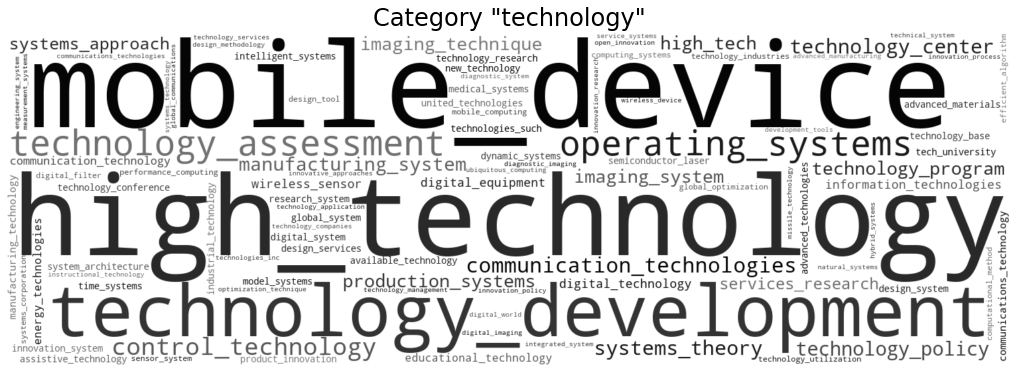

In [161]:
generate_wordcloud(corpus, 'technology')

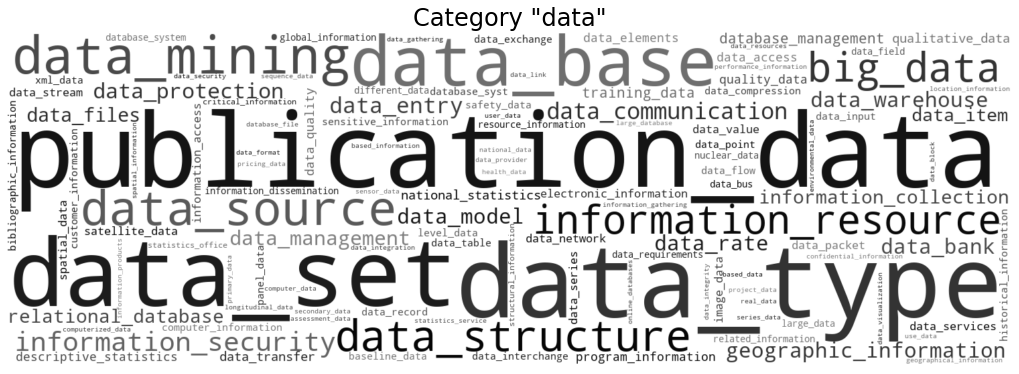

In [116]:
generate_wordcloud(corpus, 'data')

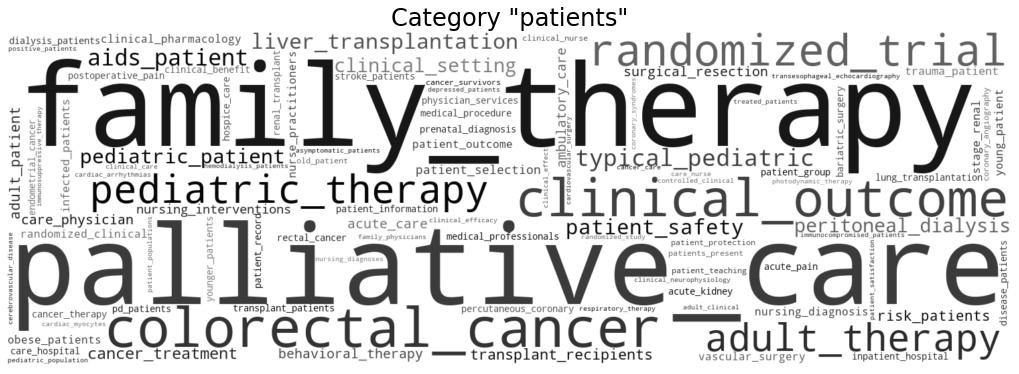

In [117]:
generate_wordcloud(corpus, 'patients')

### Analysis of mainstream speed together with categories

In [153]:
df = plotpd

In [154]:
# Create two new columns about the speed
df['years_to_peak'] = df['peak_year']-df['start_of_mainstreaming']

conditions = [
    (df['years_to_peak'] < 5),
    (df['years_to_peak'] < 10),
    (df['years_to_peak'] < 15),
    (df['years_to_peak'] < 20)]
choices = ['VeryFast', 'Fast', 'Medium', 'Slow']
df['peak_speed'] = np.select(conditions, choices, default='VerySlow')

In [155]:
test = df[['peak_speed','category','bigram']].groupby(['peak_speed','category'], as_index=False).count()
test = test.astype({'bigram': 'double'})
testcopy = test.copy()

In [156]:
valuecountDict = dict(df['category'].value_counts())
for i in range(0, len(test)):
    testcopy['bigram'][i] = test['bigram'][i]/float(valuecountDict[test['category'][i]])

<ipython-input-156-e9e84043ecb0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testcopy['bigram'][i] = test['bigram'][i]/float(valuecountDict[test['category'][i]])


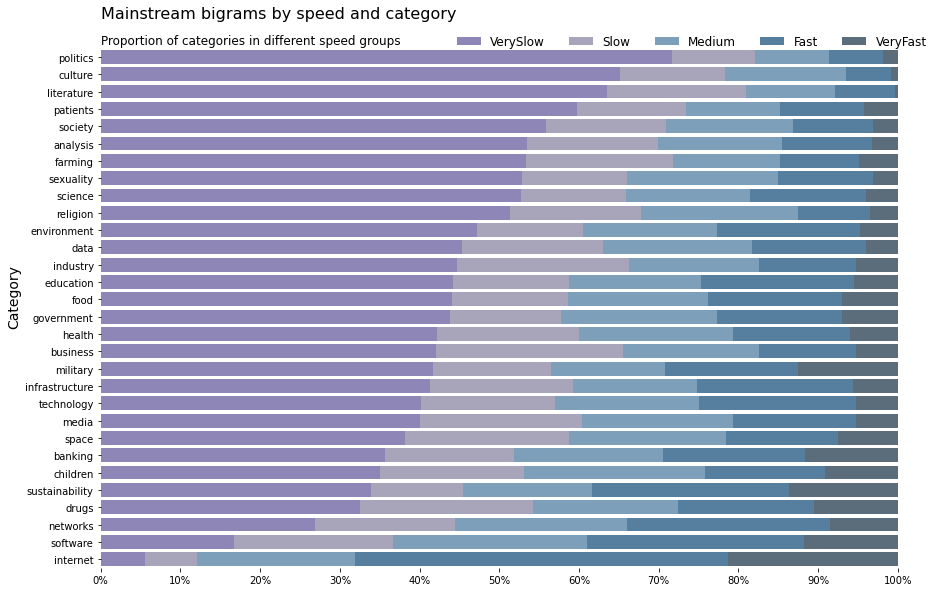

In [174]:
# plot

sorter = list(testcopy[testcopy.peak_speed == 'VerySlow'].sort_values('bigram', ascending=False).category)
testcopy.category = testcopy.category.astype("category")
testcopy.category.cat.set_categories(sorter,inplace=True)
testcopy.sort_values(["peak_speed", "category"],ascending=False,inplace=True)

fig, ax = plt.subplots(1, figsize=(15, 10))

SpeedDict = ['VerySlow', 'Slow', 'Medium', 'Fast', 'VeryFast']
colors = ['#8D86B7', '#A8A5BA', '#7D9FB9', '#567F9F', '#5B6C7A']

left_placement = testcopy[testcopy['peak_speed'] == SpeedDict[0]]['bigram'] * 0
left_placement = left_placement.reset_index()['bigram']
i = 0
for key in SpeedDict:
    tmp = testcopy[testcopy['peak_speed'] == key]
    tmp = tmp.reset_index()
    plt.barh(tmp['category'], tmp['bigram']*100, left=left_placement, color = colors[i])
    left_placement = left_placement + tmp['bigram']*100
    i = i + 1
    
plt.legend(SpeedDict, ncol=5, frameon=False, fontsize=12, loc='upper right')
plt.ylabel('Category', fontsize='14')
plt.ylim(-0.5)

xticks = np.arange(0,101,10)
xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks(xticks, xlabels)

plt.title('Mainstream bigrams by speed and category', loc='left', fontsize=16)
plt.text(0, ax.get_yticks()[-1] + 0.75, 'Proportion of categories in different speed groups', fontsize=12)
plt.savefig('speed_category',bbox_inches='tight')  
plt.show()